In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns

In [4]:
df = pd.read_csv('Data/household_power_consumption.txt', sep=';', header=0)
print(df.head())
print(df.info())

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column      

In [5]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

In [6]:
df_prophet = df[['Datetime', 'Global_active_power']].copy()

In [7]:
df_prophet.rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

In [8]:
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

In [9]:
df_prophet.dropna(inplace=True)

In [10]:
print(df_prophet.head())
print(df_prophet.info())

                   ds      y
0 2006-12-16 17:24:00  4.216
1 2006-12-16 17:25:00  5.360
2 2006-12-16 17:26:00  5.374
3 2006-12-16 17:27:00  5.388
4 2006-12-16 17:28:00  3.666
<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ds      datetime64[ns]
 1   y       float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 46.9 MB
None


In [11]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]


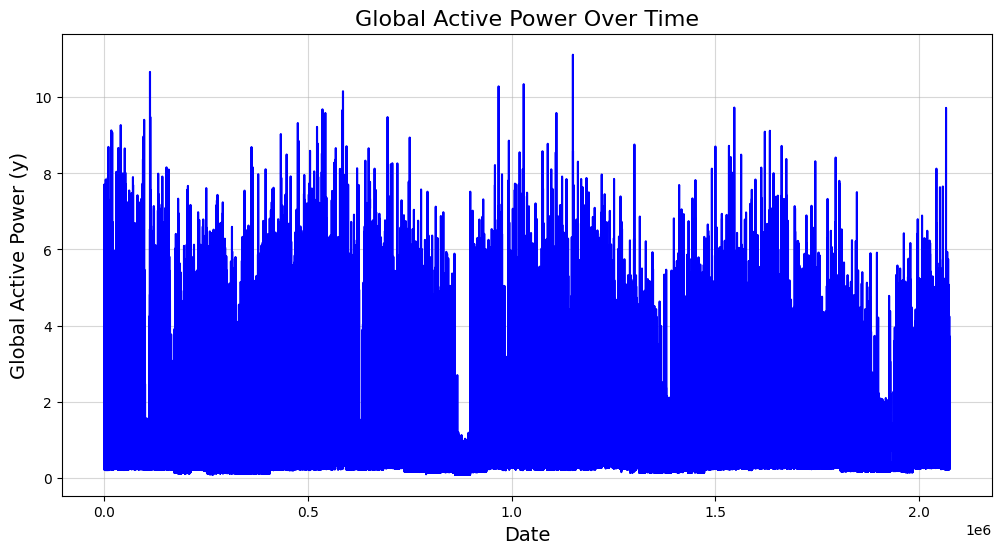

In [11]:
plt.figure(figsize=(12, 6))
df_prophet['y'].plot(color='blue', linewidth=1.5)
plt.title('Global Active Power Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Global Active Power (y)', fontsize=14)
plt.grid(alpha=0.5)
plt.show()

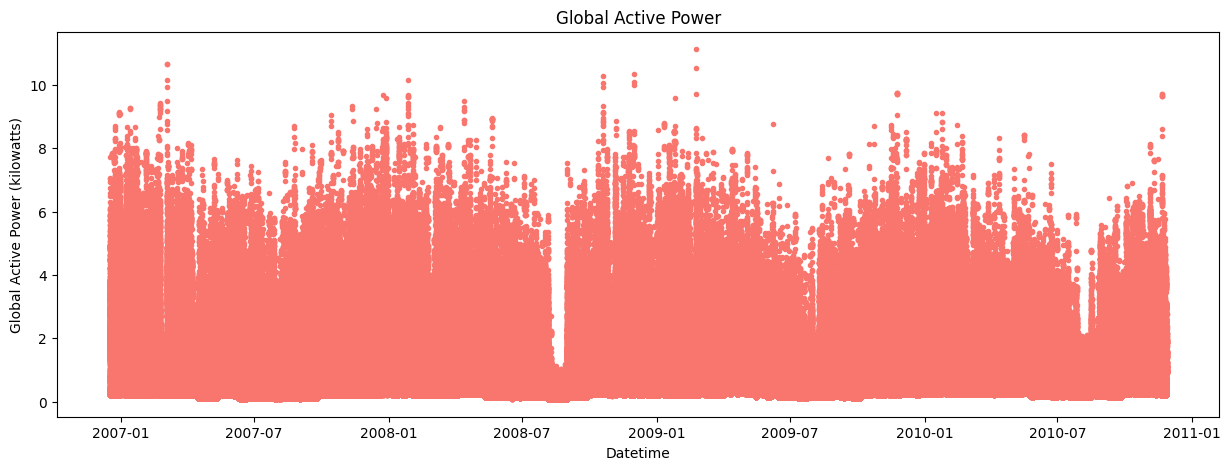

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], '.', color=color_pal[0])
plt.title('Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatts)')
plt.show()

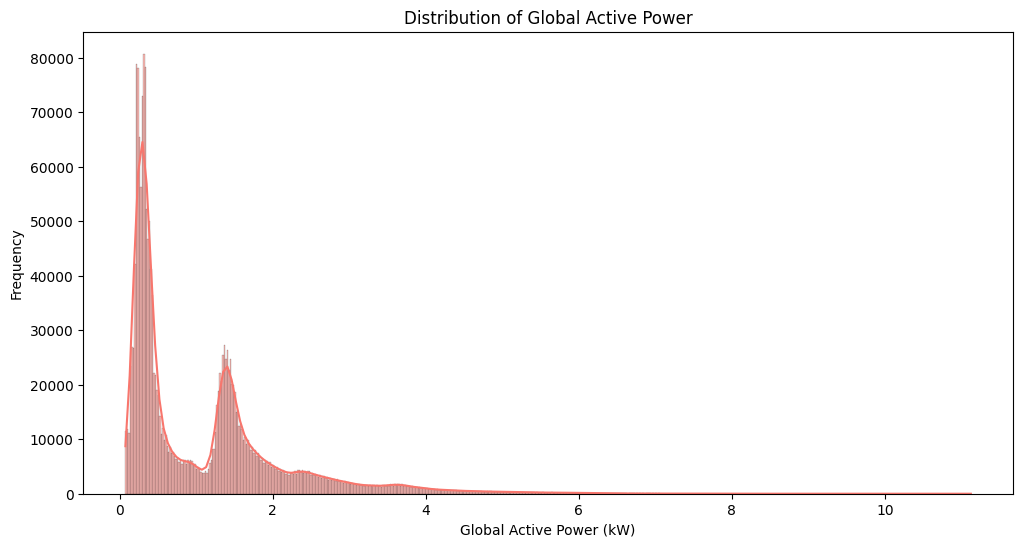

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df_prophet['y'], kde=True, color=color_pal[0])
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequency')
plt.show()


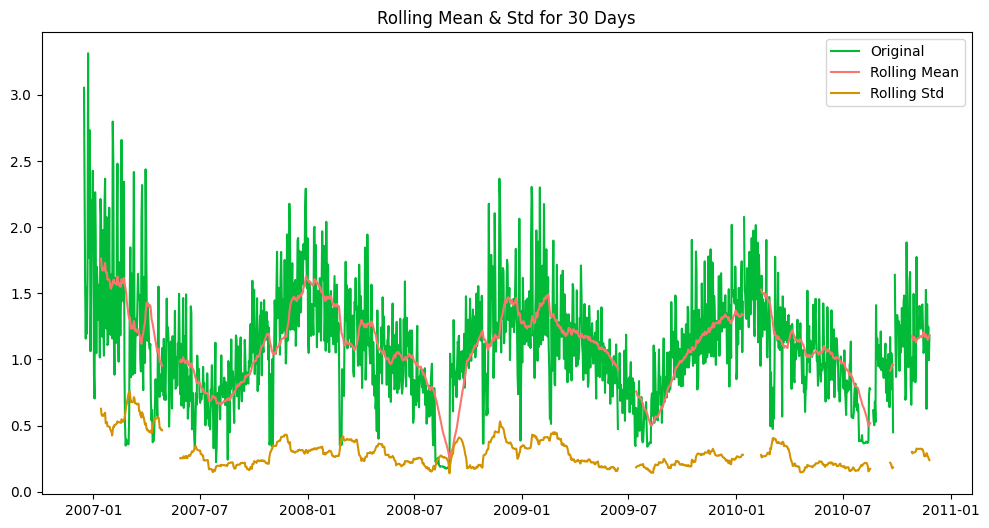

In [10]:
window_size = 30  # 30 days window
df_prophet_daily = df_prophet.resample('D', on='ds').mean()
df_prophet_daily['Rolling_Mean'] = df_prophet_daily['y'].rolling(window=window_size).mean()
df_prophet_daily['Rolling_Std'] = df_prophet_daily['y'].rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(df_prophet_daily['y'], label='Original', color=color_pal[3])
plt.plot(df_prophet_daily['Rolling_Mean'], label='Rolling Mean', color=color_pal[0])
plt.plot(df_prophet_daily['Rolling_Std'], label='Rolling Std', color=color_pal[1])
plt.title(f'Rolling Mean & Std for {window_size} Days')
plt.legend()
plt.show()


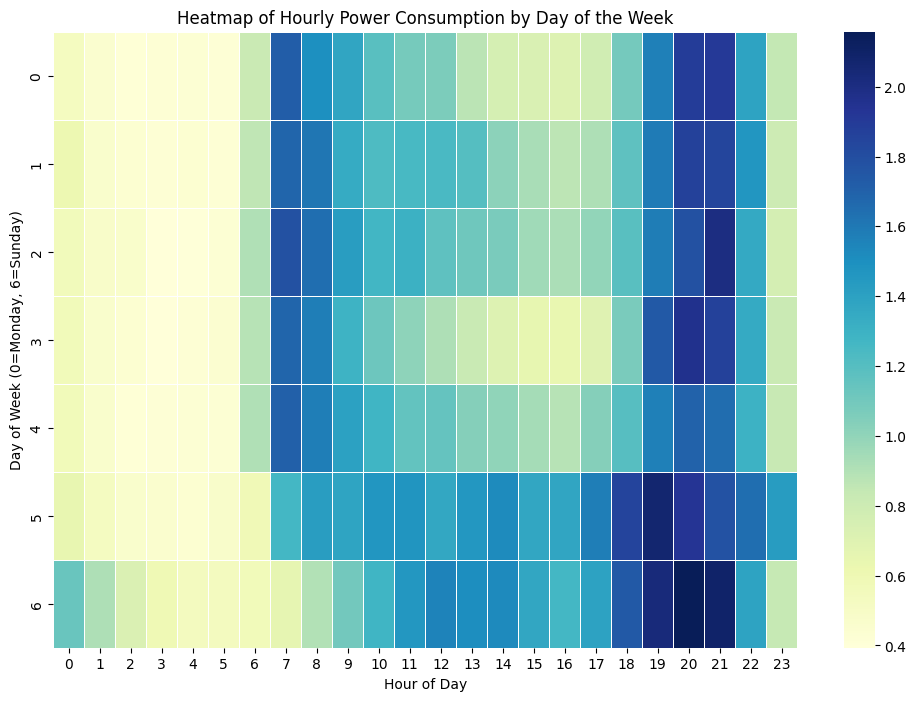

In [25]:
df_prophet['Hour'] = df_prophet['ds'].dt.hour
df_prophet['Weekday'] = df_prophet['ds'].dt.weekday

heatmap_data = df_prophet.pivot_table(index='Weekday', columns='Hour', values='y', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, fmt=".1f", linewidths=0.5)
plt.title('Heatmap of Hourly Power Consumption by Day of the Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
plt.show()


/tmp/ipykernel_12558/929045383.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_prophet, x='Weekday', y='y', palette="Set3")


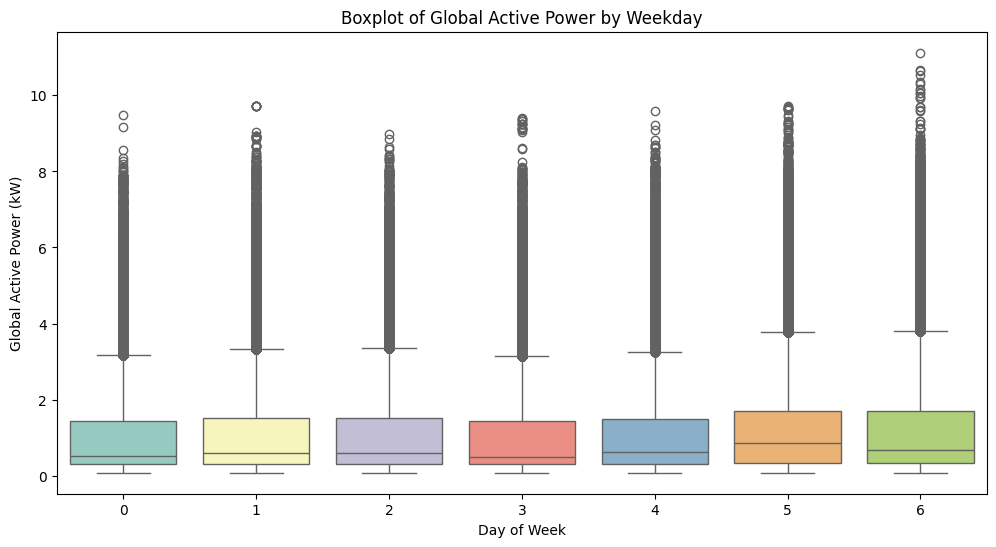

In [28]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_prophet, x='Weekday', y='y', palette="Set3")
plt.title('Boxplot of Global Active Power by Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Global Active Power (kW)')
plt.show()

/tmp/ipykernel_12558/2027730852.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_prophet, x='Hour', y='y', palette="Set3")


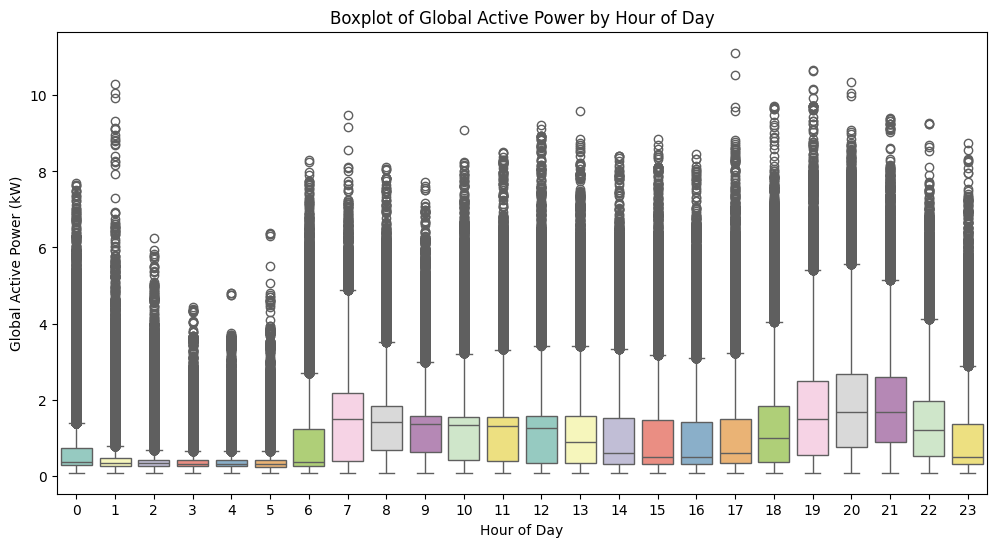

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_prophet, x='Hour', y='y', palette="Set3")
plt.title('Boxplot of Global Active Power by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Global Active Power (kW)')
plt.show()


In [10]:
def create_features(df, label=None):
    df['hour'], df['dayofweek'], df['quarter'] = df['ds'].dt.hour, df['ds'].dt.dayofweek, df['ds'].dt.quarter
    df['month'], df['year'], df['dayofyear'] = df['ds'].dt.month, df['ds'].dt.year, df['ds'].dt.dayofyear
    df['dayofmonth'], df['weekofyear'] = df['ds'].dt.day, df['ds'].dt.isocalendar().week
    
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
    return (X, df[label]) if label else X

X, y = create_features(df_prophet, label='y')
features_and_target = pd.concat([X, y], axis=1)

print(features_and_target.head())

   hour  dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear  \
0    17          5        4     12  2006        350          16          50   
1    17          5        4     12  2006        350          16          50   
2    17          5        4     12  2006        350          16          50   
3    17          5        4     12  2006        350          16          50   
4    17          5        4     12  2006        350          16          50   

       y  
0  4.216  
1  5.360  
2  5.374  
3  5.388  
4  3.666  


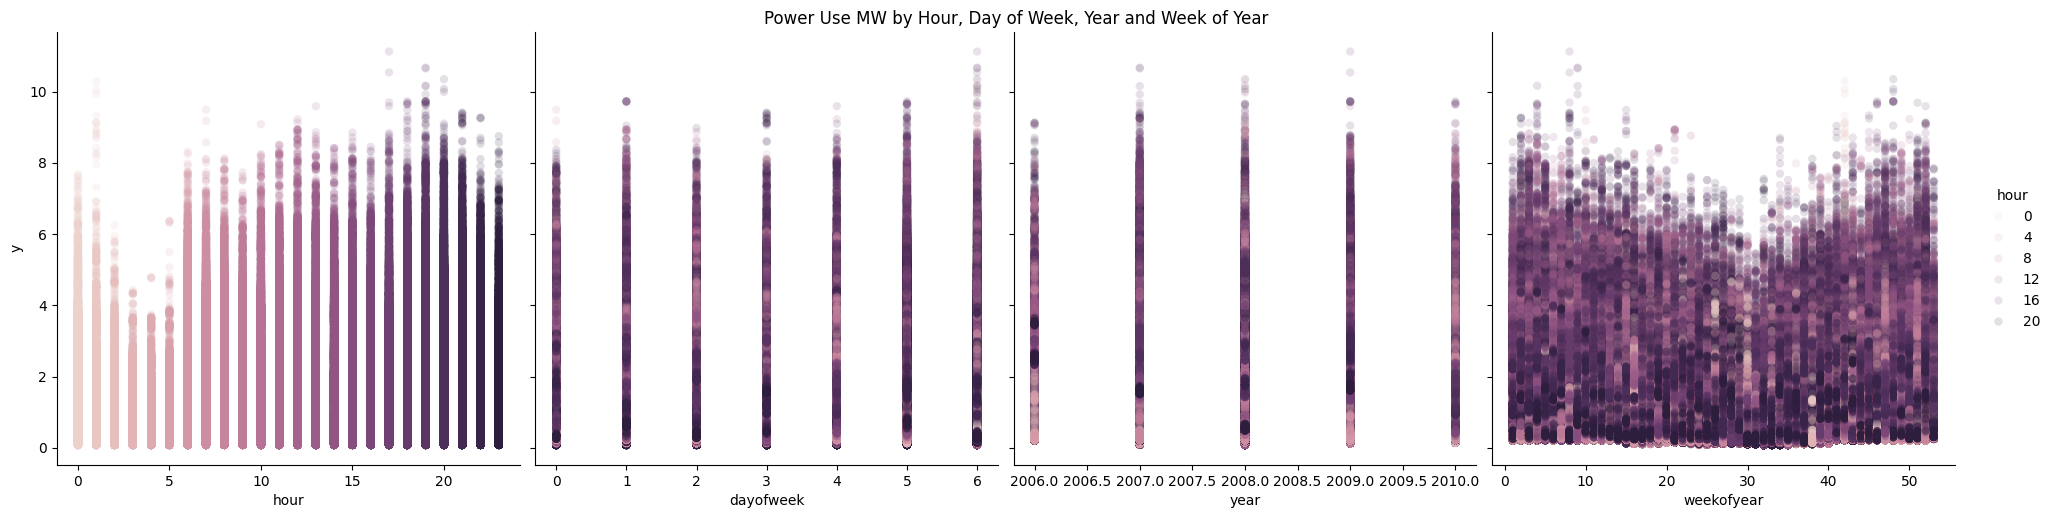

In [11]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour', 'dayofweek', 'year', 'weekofyear'],
             y_vars=['y'], 
             height=5,
             plot_kws={'alpha': 0.15, 'linewidth': 0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year', y=1.02)
plt.show()

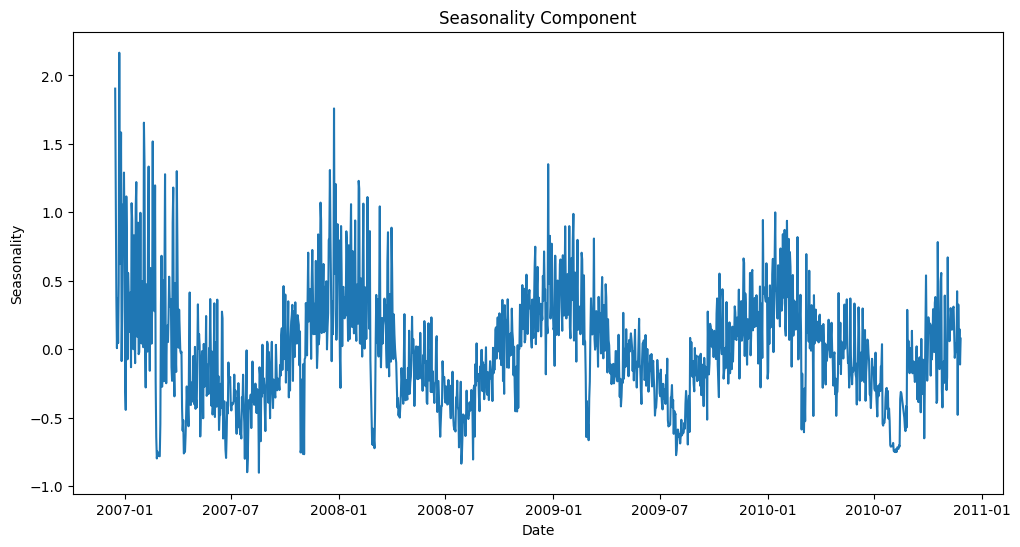

In [11]:
from statsmodels.tsa.seasonal import STL

df_prophet_daily = df_prophet.resample('D', on='ds').mean()
df_prophet_daily = df_prophet_daily.dropna(subset=['y'])

period = 365  # data's frequency

# STL decomposition
stl = STL(df_prophet_daily['y'], period=period, robust=True)
result = stl.fit()

# Plot the seasonal component
plt.figure(figsize=(12, 6))
plt.plot(result.seasonal)
plt.title('Seasonality Component')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.show()


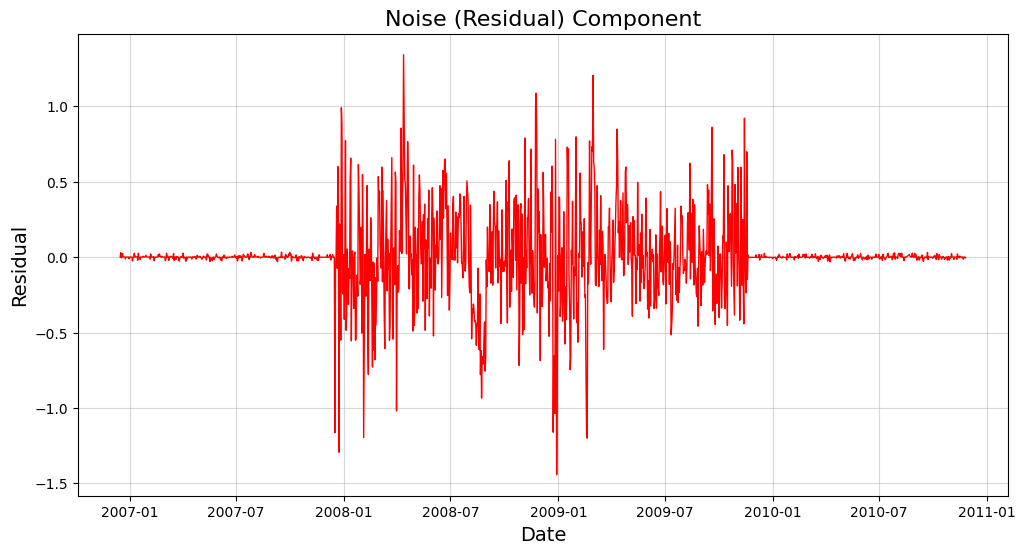

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(result.resid, color='red', linewidth=1)
plt.title('Noise (Residual) Component', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.grid(alpha=0.5)
plt.show()

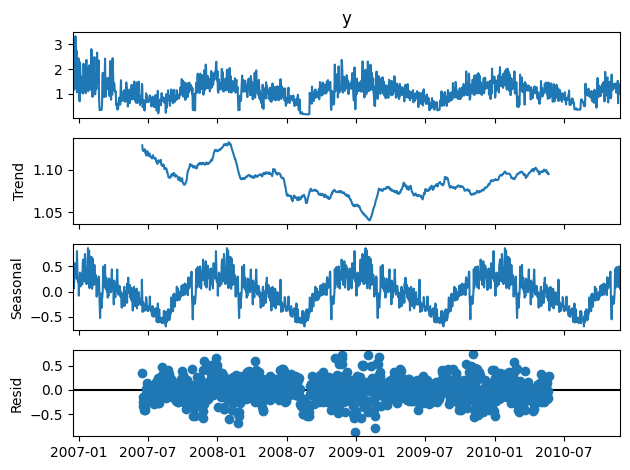

In [14]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df_prophet_daily['y'], period=365)
fig = decomposition.plot()
plt.show()

In [12]:
Q1 = df_prophet['y'].quantile(0.25)
Q3 = df_prophet['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_prophet = df_prophet[(df_prophet['y'] >= lower_bound) & (df_prophet['y'] <= upper_bound)]

In [13]:
df_prophet

,ds,y
16,2006-12-16 17:40:00,3.270
18,2006-12-16 17:42:00,3.266
25,2006-12-16 17:49:00,3.248
26,2006-12-16 17:50:00,3.236
27,2006-12-16 17:51:00,3.228
...,...,...
2075254,2010-11-26 20:58:00,0.946
2075255,2010-11-26 20:59:00,0.944
2075256,2010-11-26 21:00:00,0.938
2075257,2010-11-26 21:01:00,0.934


In [14]:
split_pct = 0.80  # 80% training, 20% testing

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
split_index = int(len(df_prophet) * split_pct)

prophet_train_min = df_prophet.iloc[:split_index][['ds', 'y']].copy()
prophet_test_min = df_prophet.iloc[split_index:][['ds', 'y']].copy()

print("Training data shape:", prophet_train_min.shape)
print("Testing data shape:", prophet_test_min.shape)


Training data shape: (1563498, 2)
Testing data shape: (390875, 2)


In [15]:
prophet_train_min['ds'] = pd.to_datetime(prophet_train_min['ds'], errors='coerce')
prophet_test_min['ds'] = pd.to_datetime(prophet_test_min['ds'], errors='coerce')

prophet_train_min.set_index('ds', inplace=True)
prophet_test_min.set_index('ds', inplace=True)

# Resampling to hourly data by taking the mean of 'y' values
prophet_train = prophet_train_min.resample('H').mean()
prophet_test = prophet_test_min.resample('H').mean()

prophet_train.reset_index(inplace=True)
prophet_test.reset_index(inplace=True)

print("Training data shape:", prophet_train.shape)
print("Testing data shape:", prophet_test.shape)

print("Training data sample:")
print(prophet_train.head())
print("Testing data sample:")
print(prophet_test.head())


Training data shape: (27658, 2)
Testing data shape: (6932, 2)
Training data sample:
                   ds         y
0 2006-12-16 17:00:00  3.097333
1 2006-12-16 18:00:00  2.664533
2 2006-12-16 19:00:00  3.272000
3 2006-12-16 20:00:00  3.193500
4 2006-12-16 21:00:00  2.745939
Testing data sample:
                   ds         y
0 2010-02-11 02:00:00  0.302936
1 2010-02-11 03:00:00  0.361167
2 2010-02-11 04:00:00  0.632600
3 2010-02-11 05:00:00  0.661667
4 2010-02-11 06:00:00  0.556800


In [19]:
prophet_train.tail(10)

,ds,y
27648,2010-02-10 17:00:00,1.468467
27649,2010-02-10 18:00:00,1.770300
27650,2010-02-10 19:00:00,1.690967
27651,2010-02-10 20:00:00,1.647627
27652,2010-02-10 21:00:00,2.316311
27653,2010-02-10 22:00:00,1.548867
27654,2010-02-10 23:00:00,0.431400
27655,2010-02-11 00:00:00,0.300367
27656,2010-02-11 01:00:00,0.299833
27657,2010-02-11 02:00:00,0.316154


In [43]:
print(prophet_train.tail(10))
print(prophet_test.tail(10))

                       ds         y
27648 2010-02-10 17:00:00  1.468467
27649 2010-02-10 18:00:00  1.770300
27650 2010-02-10 19:00:00  1.690967
27651 2010-02-10 20:00:00  1.647627
27652 2010-02-10 21:00:00  2.316311
27653 2010-02-10 22:00:00  1.548867
27654 2010-02-10 23:00:00  0.431400
27655 2010-02-11 00:00:00  0.300367
27656 2010-02-11 01:00:00  0.299833
27657 2010-02-11 02:00:00  0.316154
                      ds         y
6922 2010-11-26 12:00:00  1.490200
6923 2010-11-26 13:00:00  1.612933
6924 2010-11-26 14:00:00  1.407767
6925 2010-11-26 15:00:00  0.876433
6926 2010-11-26 16:00:00  1.067933
6927 2010-11-26 17:00:00  1.725900
6928 2010-11-26 18:00:00  1.573467
6929 2010-11-26 19:00:00  1.659333
6930 2010-11-26 20:00:00  1.163700
6931 2010-11-26 21:00:00  0.934667


In [16]:
print("Training data shape:", prophet_train.shape)
print("Testing data shape:", prophet_test.shape)

Training data shape: (27658, 2)
Testing data shape: (6932, 2)


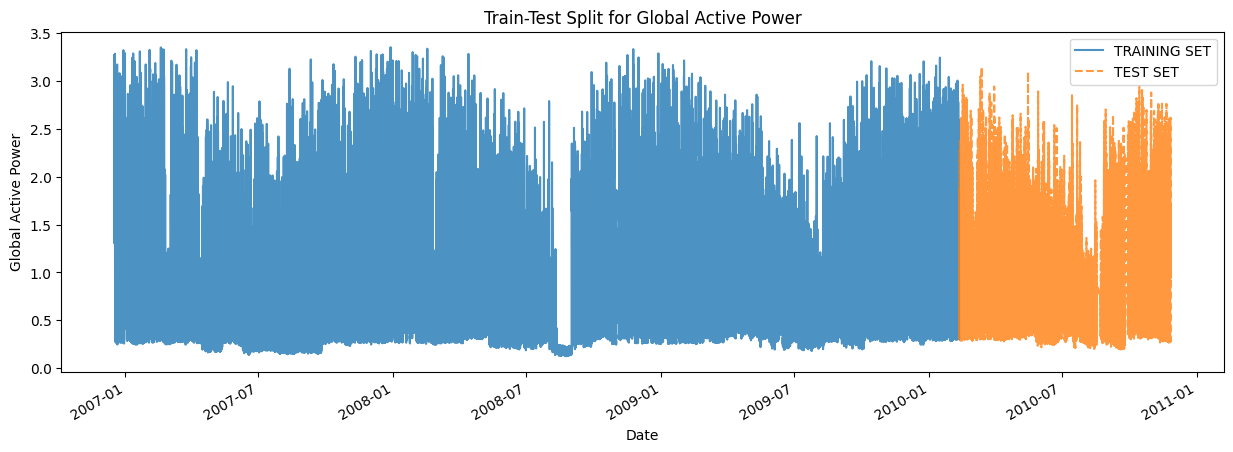

In [23]:
train_for_plot = prophet_train.copy()
test_for_plot = prophet_test.copy()

train_for_plot = train_for_plot.rename(columns={'y': 'TRAINING SET'})
test_for_plot = test_for_plot.rename(columns={'y': 'TEST SET'})

df_combined = pd.merge(
    train_for_plot[['ds', 'TRAINING SET']],
    test_for_plot[['ds', 'TEST SET']],
    on='ds',
    how='outer'
)

ax = df_combined.set_index('ds').plot(
    figsize=(15, 5),
    title='Train-Test Split for Global Active Power',
    style=['-', '--'], 
    alpha=0.8 
)

ax.set_xlabel('Date')
ax.set_ylabel('Global Active Power')
plt.show()


In [24]:
prophet_train.dropna(inplace=True)
prophet_test.dropna(inplace=True)

In [30]:
import optuna
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd

In [31]:
def objective(trial):
    changepoint_prior_scale = trial.suggest_loguniform("changepoint_prior_scale", 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_loguniform("seasonality_prior_scale", 0.01, 10.0)
    holidays_prior_scale = trial.suggest_loguniform("holidays_prior_scale", 0.01, 10.0)
    
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
    )
    
    model.fit(prophet_train)
    df_cv = cross_validation(model, horizon="30 days", parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    return df_p["rmse"].values[0]

In [33]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2024-11-22 18:36:51,100] A new study created in memory with name: no-name-00ee76f1-62fb-4cbf-8bbc-129804b2e6c9
18:36:53 - cmdstanpy - INFO - Chain [1] start processing
18:36:58 - cmdstanpy - INFO - Chain [1] done processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing
18:37:03 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] done processing
18:37:04 - cmdstanpy - INFO - Chain [1] start processing
18:37:04 - cmdstanpy - INFO - Chain [1] start processing
18:37:05 - cmdstanpy - INFO - Chain [1] start processing
18:37:05 - cmdstanpy - INFO - Chain [1] done processing
18:37:05 - cmdstanpy - INFO - Chain [

In [34]:
best_params = study.best_params
print("Best hyperparameters:", best_params)

Best hyperparameters: {'changepoint_prior_scale': 0.0038695933526709967, 'seasonality_prior_scale': 0.01121392423345686, 'holidays_prior_scale': 2.2466912694115466}


In [99]:
model = Prophet(**best_params)
model.fit(prophet_train)

study.trials_dataframe().to_csv("optuna_study_results.csv", index=False)

20:29:54 - cmdstanpy - INFO - Chain [1] start processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
prophet_fcast=model.predict(prophet_test)
prophet_fcast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-11 02:00:00,0.976920,-0.080894,1.382732,0.976920,0.976920,-0.317725,-0.317725,-0.317725,-0.530979,...,-0.059697,-0.059697,-0.059697,0.272951,0.272951,0.272951,0.0,0.0,0.0,0.659195
1,2010-02-11 03:00:00,0.976920,-0.167601,1.354339,0.976920,0.976920,-0.383515,-0.383515,-0.383515,-0.592950,...,-0.062442,-0.062442,-0.062442,0.271878,0.271878,0.271878,0.0,0.0,0.0,0.593405
2,2010-02-11 04:00:00,0.976919,-0.191121,1.351513,0.976919,0.976919,-0.391007,-0.391007,-0.391007,-0.596834,...,-0.064975,-0.064975,-0.064975,0.270802,0.270802,0.270802,0.0,0.0,0.0,0.585912
3,2010-02-11 05:00:00,0.976919,-0.068777,1.455273,0.976919,0.976919,-0.251657,-0.251657,-0.251657,-0.454091,...,-0.067290,-0.067290,-0.067290,0.269724,0.269724,0.269724,0.0,0.0,0.0,0.725262
4,2010-02-11 06:00:00,0.976918,0.263846,1.739852,0.976918,0.976918,0.042250,0.042250,0.042250,-0.157009,...,-0.069384,-0.069384,-0.069384,0.268643,0.268643,0.268643,0.0,0.0,0.0,1.019168


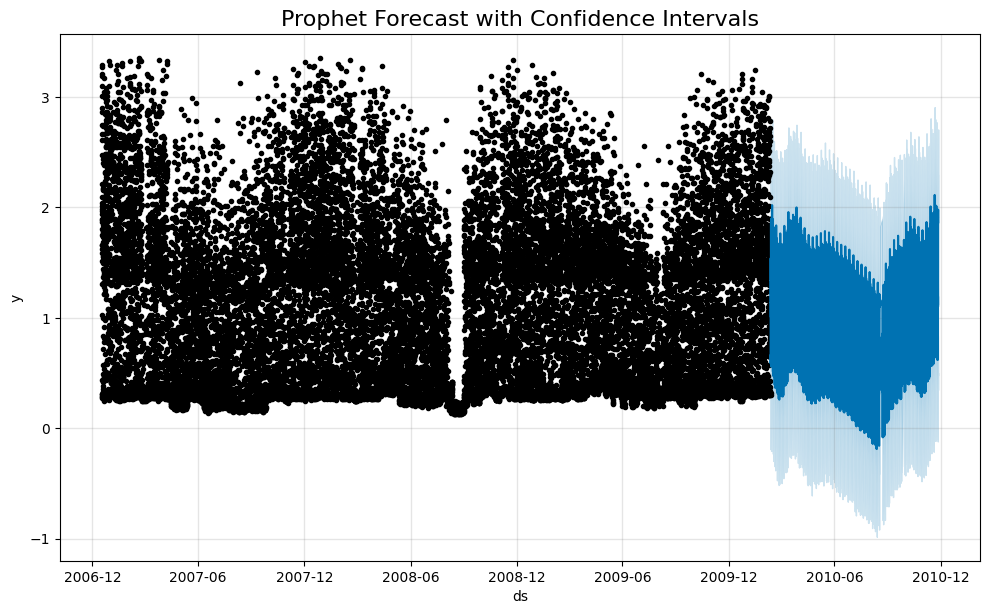

In [51]:
fig1 = model.plot(prophet_fcast)
plt.title('Prophet Forecast with Confidence Intervals', fontsize=16)
plt.show()

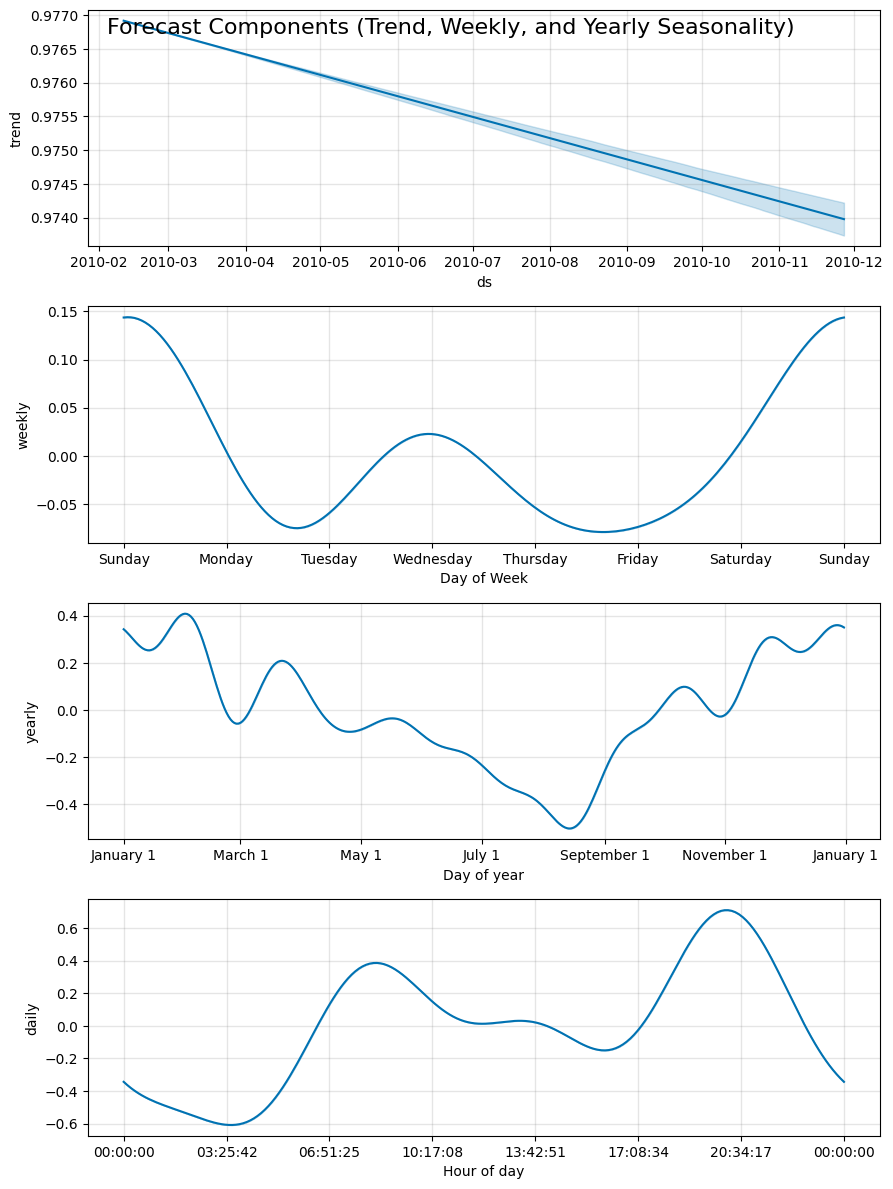

In [55]:
fig2 = model.plot_components(prophet_fcast)
plt.suptitle('Forecast Components (Trend, Weekly, and Yearly Seasonality)', fontsize=16)
plt.show()

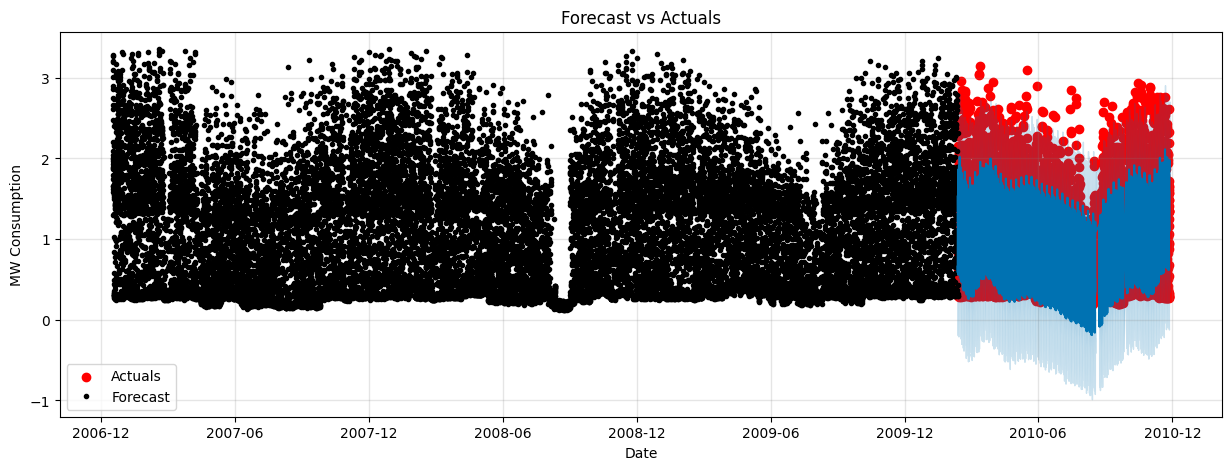

In [39]:
# comparing with actuals vs predicted
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

ax.scatter(
    prophet_test['ds'], 
    prophet_test['y'],   
    color='r',
    label='Actuals'
)

# Plotting the forecast using Prophet's built-in function
fig = model.plot(prophet_fcast, ax=ax)

ax.set_title('Forecast vs Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('MW Consumption')
ax.legend(['Actuals', 'Forecast'])

plt.show()


In [74]:
prophet_train

,ds,y
0,2006-12-16 17:00:00,3.097333
1,2006-12-16 18:00:00,2.664533
2,2006-12-16 19:00:00,3.272000
3,2006-12-16 20:00:00,3.193500
4,2006-12-16 21:00:00,2.745939
...,...,...
27435,2010-02-10 22:00:00,1.548867
27436,2010-02-10 23:00:00,0.431400
27437,2010-02-11 00:00:00,0.300367
27438,2010-02-11 01:00:00,0.299833


In [75]:
from workalendar.europe import France
prophet_train['ds'] = pd.to_datetime(prophet_train['ds'])
prophet_test['ds'] = pd.to_datetime(prophet_test['ds'])

prophet_train.set_index('ds', inplace=True)
prophet_test.set_index('ds', inplace=True)

cal = France()

# Extracting year ranges from the training and testing datasets
train_years = range(prophet_train.index.min().year, prophet_train.index.max().year + 1)
test_years = range(prophet_test.index.min().year, prophet_test.index.max().year + 1)

# Generating holiday dates for the training set
train_holidays = [
    pd.Timestamp(holiday[0]) for year in train_years for holiday in cal.holidays(year)
    if prophet_train.index.min() <= pd.Timestamp(holiday[0]) <= prophet_train.index.max()
]

# Generating holiday dates for the testing set
test_holidays = [
    pd.Timestamp(holiday[0]) for year in test_years for holiday in cal.holidays(year)
    if prophet_test.index.min() <= pd.Timestamp(holiday[0]) <= prophet_test.index.max()
]

# Converting to DataFrame for Prophet
train_holidays_df = pd.DataFrame({'holiday': 'French_Holidays', 'ds': train_holidays})
test_holidays_df = pd.DataFrame({'holiday': 'French_Holidays', 'ds': test_holidays})

In [77]:
print(train_holidays_df)
print(test_holidays_df)

            holiday         ds
0   French_Holidays 2006-12-25
1   French_Holidays 2007-01-01
2   French_Holidays 2007-04-09
3   French_Holidays 2007-05-01
4   French_Holidays 2007-05-08
5   French_Holidays 2007-05-17
6   French_Holidays 2007-05-28
7   French_Holidays 2007-07-14
8   French_Holidays 2007-08-15
9   French_Holidays 2007-11-01
10  French_Holidays 2007-11-11
11  French_Holidays 2007-12-25
12  French_Holidays 2008-01-01
13  French_Holidays 2008-03-24
14  French_Holidays 2008-05-01
15  French_Holidays 2008-05-01
16  French_Holidays 2008-05-08
17  French_Holidays 2008-05-12
18  French_Holidays 2008-07-14
19  French_Holidays 2008-08-15
20  French_Holidays 2008-11-01
21  French_Holidays 2008-11-11
22  French_Holidays 2008-12-25
23  French_Holidays 2009-01-01
24  French_Holidays 2009-04-13
25  French_Holidays 2009-05-01
26  French_Holidays 2009-05-08
27  French_Holidays 2009-05-21
28  French_Holidays 2009-06-01
29  French_Holidays 2009-07-14
30  French_Holidays 2009-08-15
31  Fren

In [79]:
all_holidays_df = pd.concat([train_holidays_df, test_holidays_df], ignore_index=True)

In [92]:
def objective(trial):
    changepoint_prior_scale = trial.suggest_loguniform("changepoint_prior_scale", 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_loguniform("seasonality_prior_scale", 0.01, 10.0)
    holidays_prior_scale = trial.suggest_loguniform("holidays_prior_scale", 0.01, 10.0)
    
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        holidays=all_holidays_df 
    )
    
    model.fit(prophet_train)
    
    forecast = model.predict(prophet_test)
    
    df_cv = cross_validation(model, horizon="30 days", parallel="processes")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    return df_p["rmse"].values[0]


In [93]:
prophet_train.reset_index(inplace=True)
prophet_test.reset_index(inplace=True)

In [94]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-11-22 20:04:30,490] A new study created in memory with name: no-name-23e15daf-8028-4888-8308-00617a8af457
20:04:31 - cmdstanpy - INFO - Chain [1] start processing
20:04:35 - cmdstanpy - INFO - Chain [1] done processing
20:04:39 - cmdstanpy - INFO - Chain [1] start processing
20:04:39 - cmdstanpy - INFO - Chain [1] start processing
20:04:39 - cmdstanpy - INFO - Chain [1] start processing
20:04:40 - cmdstanpy - INFO - Chain [1] start processing
20:04:40 - cmdstanpy - INFO - Chain [1] done processing
20:04:40 - cmdstanpy - INFO - Chain [1] done processing
20:04:40 - cmdstanpy - INFO - Chain [1] done processing
20:04:41 - cmdstanpy - INFO - Chain [1] done processing
20:04:42 - cmdstanpy - INFO - Chain [1] start processing
20:04:42 - cmdstanpy - INFO - Chain [1] start processing
20:04:42 - cmdstanpy - INFO - Chain [1] start processing
20:04:42 - cmdstanpy - INFO - Chain [1] start processing
20:04:43 - cmdstanpy - INFO - Chain [1] done processing
20:04:43 - cmdstanpy - INFO - Chain [

In [95]:
best_params_holiday = study.best_params
print("Best hyperparameters Holidays:", best_params)

Best hyperparameters Holidays: {'changepoint_prior_scale': 0.0038695933526709967, 'seasonality_prior_scale': 0.01121392423345686, 'holidays_prior_scale': 2.2466912694115466}


In [106]:
model_holiday = Prophet(**best_params_holiday)
model_holiday.fit(prophet_train)

study.trials_dataframe().to_csv("optuna_study_results_holiday.csv", index=False)

20:33:50 - cmdstanpy - INFO - Chain [1] start processing
20:33:51 - cmdstanpy - INFO - Chain [1] done processing


In [107]:
prophet_fcast_holidays=model_holiday.predict(prophet_test)
prophet_fcast_holidays.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-11 02:00:00,0.972779,-0.089450,1.436270,0.972779,0.972779,-0.325085,-0.325085,-0.325085,-0.540318,...,-0.060757,-0.060757,-0.060757,0.275990,0.275990,0.275990,0.0,0.0,0.0,0.647694
1,2010-02-11 03:00:00,0.972779,-0.115155,1.344469,0.972779,0.972779,-0.392039,-0.392039,-0.392039,-0.603389,...,-0.063551,-0.063551,-0.063551,0.274901,0.274901,0.274901,0.0,0.0,0.0,0.580740
2,2010-02-11 04:00:00,0.972778,-0.169115,1.336808,0.972778,0.972778,-0.399669,-0.399669,-0.399669,-0.607349,...,-0.066128,-0.066128,-0.066128,0.273808,0.273808,0.273808,0.0,0.0,0.0,0.573109
3,2010-02-11 05:00:00,0.972777,-0.104959,1.433572,0.972777,0.972777,-0.257868,-0.257868,-0.257868,-0.462098,...,-0.068484,-0.068484,-0.068484,0.272714,0.272714,0.272714,0.0,0.0,0.0,0.714910
4,2010-02-11 06:00:00,0.972777,0.310470,1.708287,0.972777,0.972777,0.041216,0.041216,0.041216,-0.159785,...,-0.070615,-0.070615,-0.070615,0.271616,0.271616,0.271616,0.0,0.0,0.0,1.013992


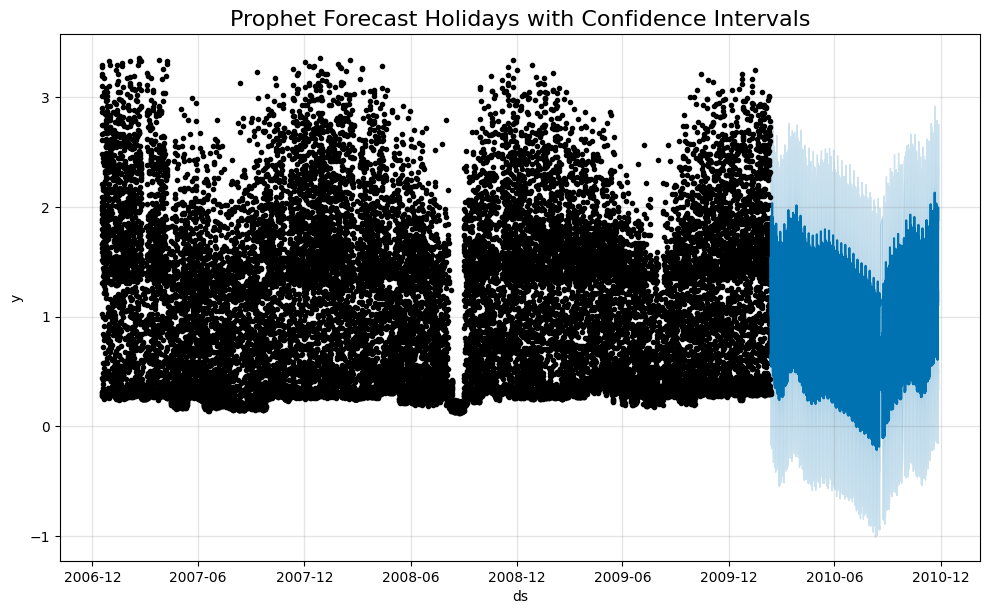

In [108]:
fig3 = model_holiday.plot(prophet_fcast_holidays)
plt.title('Prophet Forecast Holidays with Confidence Intervals', fontsize=16)
plt.show()

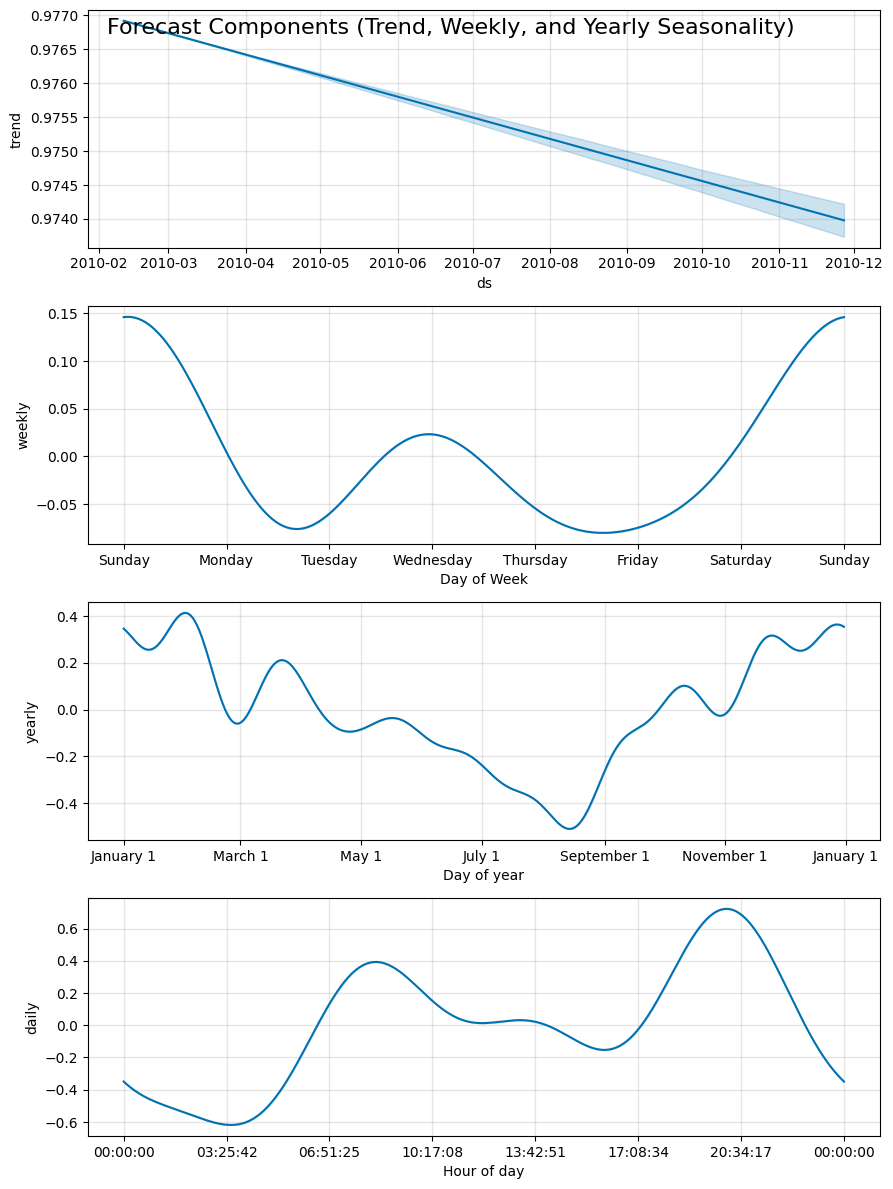

In [109]:
fig4 = model_holiday.plot_components(prophet_fcast)
plt.suptitle('Forecast Components (Trend, Weekly, and Yearly Seasonality)', fontsize=16)
plt.show()

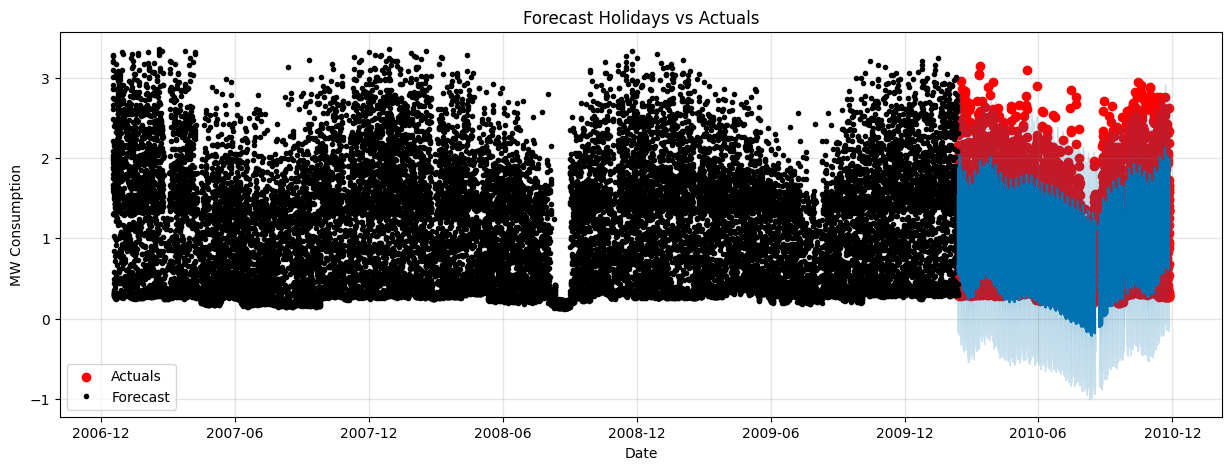

In [112]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

ax.scatter(
    prophet_test['ds'], 
    prophet_test['y'],   
    color='r',
    label='Actuals'
)

fig = model.plot(prophet_fcast_holidays, ax=ax)

ax.set_title('Forecast Holidays vs Actuals')
ax.set_xlabel('Date')
ax.set_ylabel('MW Consumption')
ax.legend(['Actuals', 'Forecast'])

plt.show()
